⬇️ Downloading RAVDESS dataset...


Downloading: 100%|██████████| 208M/208M [00:15<00:00, 13.2MB/s]   


📂 Extracting dataset...
✅ Found 1440 audio files.
📊 Train: 1008 | Val: 216 | Test: 216


C:\Users\DEEKSHITHA CS\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


Epoch 1/10 - Train Loss: 3.5925, Val Loss: 2.1582
Epoch 2/10 - Train Loss: 2.0839, Val Loss: 2.1040
Epoch 3/10 - Train Loss: 2.0292, Val Loss: 1.9816
Epoch 4/10 - Train Loss: 1.8906, Val Loss: 2.0682
Epoch 5/10 - Train Loss: 1.8908, Val Loss: 2.0453
Epoch 6/10 - Train Loss: 1.8418, Val Loss: 2.0067
Epoch 7/10 - Train Loss: 1.8141, Val Loss: 1.8140
Epoch 8/10 - Train Loss: 1.7700, Val Loss: 2.1273
Epoch 9/10 - Train Loss: 1.8471, Val Loss: 1.8499
Epoch 10/10 - Train Loss: 1.8450, Val Loss: 2.0576


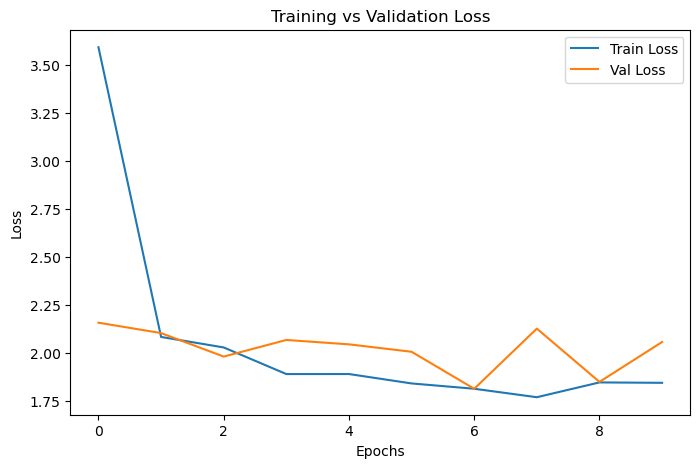


✅ Test Accuracy: 0.24537037037037038
              precision    recall  f1-score   support

     neutral       0.00      0.00      0.00        14
        calm       0.00      0.00      0.00        28
       happy       0.24      0.38      0.29        29
         sad       0.16      0.76      0.27        29
       angry       0.58      0.38      0.46        29
     fearful       0.56      0.31      0.40        29
     disgust       0.00      0.00      0.00        29
   surprised       0.00      0.00      0.00        29

    accuracy                           0.25       216
   macro avg       0.19      0.23      0.18       216
weighted avg       0.21      0.25      0.19       216

Confusion Matrix:
 [[ 0  0  2 12  0  0  0  0]
 [ 0  0  1 27  0  0  0  0]
 [ 0  0 11 12  4  2  0  0]
 [ 0  0  4 22  0  3  0  0]
 [ 0  0  9  8 11  1  0  0]
 [ 0  0  7 13  0  9  0  0]
 [ 0  0  4 21  4  0  0  0]
 [ 0  0  8 20  0  1  0  0]]


C:\Users\DEEKSHITHA CS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEEKSHITHA CS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\DEEKSHITHA CS\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [3]:
# 1. Install Dependencies
!pip install torch torchaudio librosa soundfile numpy scipy scikit-learn matplotlib tqdm requests --quiet

# 2. Download & Extract Dataset
import os, zipfile, requests, glob
from tqdm import tqdm
DATASET_PATH = "./datasets/ravdess"
os.makedirs(DATASET_PATH, exist_ok=True)
url = "https://zenodo.org/record/1188976/files/Audio_Speech_Actors_01-24.zip?download=1"
zip_path = os.path.join(DATASET_PATH, "ravdess.zip")

# Download dataset if not exists
if not os.path.exists(zip_path):
    print("⬇️ Downloading RAVDESS dataset...")
    response = requests.get(url, stream=True)
    total_size = int(response.headers.get('content-length', 0))
    with open(zip_path, 'wb') as f, tqdm(
        desc="Downloading", total=total_size, unit='B', unit_scale=True
    ) as bar:
        for data in response.iter_content(chunk_size=1024):
            f.write(data)
            bar.update(len(data))
else:
    print(" RAVDESS zip already exists.")

# Extract if not already
if not glob.glob(os.path.join(DATASET_PATH, "Actor_*")):
    print(" Extracting dataset...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(DATASET_PATH)
else:
    print(" RAVDESS dataset already extracted.")

# Verify
wav_files = glob.glob(os.path.join(DATASET_PATH, "**/*.wav"), recursive=True)
print(f" Found {len(wav_files)} audio files.")

#  3. Setup Dataset Class
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Emotion map (RAVDESS)
EMOTION_MAP = {
    "01": "neutral", "02": "calm", "03": "happy", "04": "sad",
    "05": "angry", "06": "fearful", "07": "disgust", "08": "surprised"
}

SAMPLE_RATE = 22050
DURATION = 3
SAMPLES_PER_TRACK = SAMPLE_RATE * DURATION

class SERDataset(Dataset):
    def __init__(self, paths, labels):
        self.paths = paths
        self.labels = labels

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        path = self.paths[idx]
        label = self.labels[idx]
        y, sr = librosa.load(path, sr=SAMPLE_RATE)
        if len(y) < SAMPLES_PER_TRACK:
            y = np.pad(y, (0, SAMPLES_PER_TRACK - len(y)))
        else:
            y = y[:SAMPLES_PER_TRACK]
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        mfcc = np.mean(mfcc.T, axis=0)
        return torch.tensor(mfcc, dtype=torch.float32), torch.tensor(label, dtype=torch.long)

#  4. Build Dataset Index
def build_index():
    paths, labels = [], []
    for path in glob.glob(os.path.join(DATASET_PATH, "Actor_*", "*.wav")):
        filename = os.path.basename(path)
        emotion = filename.split("-")[2]
        if emotion in EMOTION_MAP:
            paths.append(path)
            labels.append(int(emotion)-1)
    paths, labels = np.array(paths), np.array(labels)
    X_train, X_tmp, y_train, y_tmp = train_test_split(paths, labels, test_size=0.3, stratify=labels, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.5, stratify=y_tmp, random_state=42)
    return {'train': (X_train, y_train), 'val': (X_val, y_val), 'test': (X_test, y_test)}

index = build_index()
print(f"Train: {len(index['train'][0])} | Val: {len(index['val'][0])} | Test: {len(index['test'][0])}")

# 5. Define Model
class EmotionModel(nn.Module):
    def __init__(self, num_classes=8):
        super(EmotionModel, self).__init__()
        self.fc1 = nn.Linear(40, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 6. Train & Evaluate
def train_model(epochs=10):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    train_ds = SERDataset(*index['train'])
    val_ds = SERDataset(*index['val'])
    test_ds = SERDataset(*index['test'])

    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=32)
    test_loader = DataLoader(test_ds, batch_size=32)

    model = EmotionModel(num_classes=8).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            preds = model(x)
            loss = criterion(preds, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                preds = model(x)
                loss = criterion(preds, y)
                val_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    # Plot loss
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.legend(); plt.xlabel("Epochs"); plt.ylabel("Loss"); plt.title("Training vs Validation Loss")
    plt.show()

    # Evaluate on test set
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            preds = model(x)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(torch.argmax(preds, axis=1).cpu().numpy())

    print("\n✅ Test Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=list(EMOTION_MAP.values())))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

train_model(epochs=10)
